In [1]:
"""
Wallet Model Training & Explainability Notebook
================================================

End-to-end Jupyter/VS Code notebook that

1. Loads the **processed** dataset generated by *wallet_dataset_preprocessing.py*.
2. Splits the data, builds a preprocessing + Random Forest pipeline, and tunes
   hyper-parameters via `GridSearchCV`.
3. Evaluates the best model with a classification report & confusion matrix.
4. Offers two explainability blocks – **SHAP** (commented-out, optional) and
   **CIU** – for local feature influence.
5. Saves the trained pipeline (`joblib`) and the report (TXT) alongside the
   dataset for reproducibility.

Key improvements vs. the raw script:
* Uses a single `Pipeline` so the GridSearch tunes the classifier only and keeps
  preprocessing fixed.
* Retrieves feature names automatically via
  `preprocessor.get_feature_names_out()` – works even with mixed types.
* Handles older scikit-learn versions: falls back to `sparse=False` if
  `sparse_output` isn’t available.
* Cleans up unused variables and fixes the invalid attempt to access `.index`
  on NumPy arrays.
* Adds **environment variables** (`DATASET_PATH`, `MODEL_DIR`) to override
  defaults without editing code.
"""

'\nWallet Model Training & Explainability Notebook\n================================================\n\nEnd-to-end Jupyter/VS Code notebook that\n\n1. Loads the **processed** dataset generated by *wallet_dataset_preprocessing.py*.\n2. Splits the data, builds a preprocessing + Random Forest pipeline, and tunes\n   hyper-parameters via `GridSearchCV`.\n3. Evaluates the best model with a classification report & confusion matrix.\n4. Offers two explainability blocks – **SHAP** (commented-out, optional) and\n   **CIU** – for local feature influence.\n5. Saves the trained pipeline (`joblib`) and the report (TXT) alongside the\n   dataset for reproducibility.\n\nKey improvements vs. the raw script:\n* Uses a single `Pipeline` so the GridSearch tunes the classifier only and keeps\n  preprocessing fixed.\n* Retrieves feature names automatically via\n  `preprocessor.get_feature_names_out()` – works even with mixed types.\n* Handles older scikit-learn versions: falls back to `sparse=False` if\n  

In [2]:
# ----------------------------------------------------------------------
# Configuration – edit paths or set env-vars before starting Jupyter
# ----------------------------------------------------------------------
from __future__ import annotations

import os
from pathlib import Path
import warnings

DATASET_PATH = Path(os.getenv(
    "DATASET_PATH",
    "../../data/processed_data/case_3.csv",
))
MODEL_DIR = Path(os.getenv("MODEL_DIR", DATASET_PATH.parent / "models"))
MODEL_DIR.mkdir(parents=True, exist_ok=True)
REPORT_FILE = MODEL_DIR / "classification_report.txt"
MODEL_FILE  = MODEL_DIR / "rf_pipeline.joblib"

print(f"📄 Dataset: {DATASET_PATH}\n📂 Model dir: {MODEL_DIR}\n")

📄 Dataset: ../../data/processed_data/case_3.csv
📂 Model dir: ../../data/processed_data/models



In [3]:
# ----------------------------------------------------------------------
# Imports – ML stack & utilities
# ----------------------------------------------------------------------
import logging
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer confusion matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Optional explainability libs
# import shap  # uncomment if you plan to use SHAP
import ciu
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)
logging.basicConfig(level=logging.INFO, format="%(asctime)s – %(levelname)s – %(message)s")
logger = logging.getLogger(__name__)

In [4]:
# ----------------------------------------------------------------------
# Load dataset
# ----------------------------------------------------------------------
logger.info("Loading dataset…")
df = pd.read_csv(DATASET_PATH)
df = pd.concat([df], ignore_index=True)
df.drop_duplicates(inplace=True)
logger.info(f"Dataset shape: {df.shape}")

X = df.drop(columns="class")
y = df["class"]

2025-06-12 08:32:37,608 – INFO – Loading dataset…
2025-06-12 08:32:37,636 – INFO – Dataset shape: (13475, 22)


In [5]:
# ----------------------------------------------------------------------
# Identify numeric & categorical columns
# ----------------------------------------------------------------------
numeric_features      = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features  = X.select_dtypes(include=["object", "category"]).columns.tolist()
logger.info(f"Numeric  : {len(numeric_features)} columns")
logger.info(f"Categorical: {len(categorical_features)} columns")

2025-06-12 08:32:37,641 – INFO – Numeric  : 21 columns
2025-06-12 08:32:37,642 – INFO – Categorical: 0 columns


In [6]:
# ----------------------------------------------------------------------
# Preprocessing pipelines
# ----------------------------------------------------------------------
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Handle API change for OneHotEncoder (sparse_output introduced in 1.2)
onehot_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    onehot_kwargs["sparse_output"] = False
else:
    onehot_kwargs["sparse"] = False

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(**onehot_kwargs)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [7]:
# ----------------------------------------------------------------------
# Model & pipeline
# ----------------------------------------------------------------------
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf)])

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["sqrt"],
}

In [8]:
# ----------------------------------------------------------------------
# Train / validation split & GridSearch
# ----------------------------------------------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

logger.info("Splitting train/test…")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

logger.info("Starting GridSearchCV…")
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)

grid_search.fit(X_train, y_train)
logger.info(f"Best params: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

2025-06-12 08:32:37,654 – INFO – Splitting train/test…
2025-06-12 08:32:37,657 – INFO – Starting GridSearchCV…


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.8s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.8s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__max_dept

2025-06-12 08:32:57,722 – INFO – Best params: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


2025-06-12 08:32:57,772 – INFO – Classification report saved → ../../data/processed_data/models/classification_report.txt


              precision    recall  f1-score   support

       fraud       0.92      0.91      0.91      1269
       licit       0.92      0.93      0.92      1426

    accuracy                           0.92      2695
   macro avg       0.92      0.92      0.92      2695
weighted avg       0.92      0.92      0.92      2695



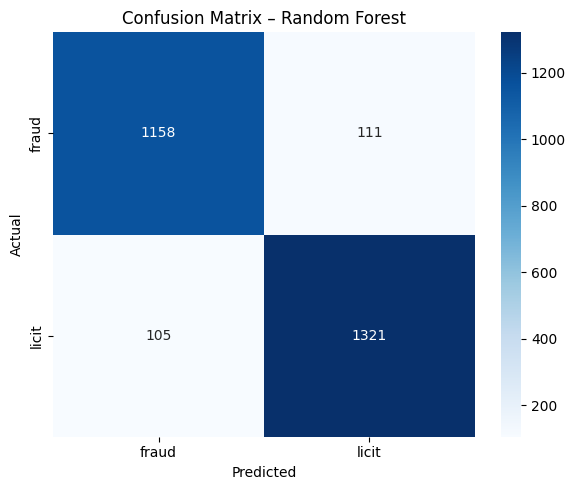

In [9]:
# ----------------------------------------------------------------------
# Evaluation
# ----------------------------------------------------------------------
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
cm      = confusion_matrix(y_test, y_pred)

print(report)

# Save the textual report
REPORT_FILE.write_text(report)
logger.info(f"Classification report saved → {REPORT_FILE}")

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [10]:
# ----------------------------------------------------------------------
# Persist the trained pipeline
# ----------------------------------------------------------------------
joblib.dump(best_model, MODEL_FILE)
logger.info(f"Model pipeline saved → {MODEL_FILE}")

# %% [markdown]
"""
## 🔍 Local Explainability with CIU
Below cells provide a ready‑made block to analyse feature influence for a
single test instance using CIU ([*Contextual Importance & Utility*](https://github.com/TrustAI/py‑ciu)).

*Change `instance_idx` to explore different samples.*
"""

2025-06-12 08:32:57,979 – INFO – Model pipeline saved → ../../data/processed_data/models/rf_pipeline.joblib


'\n## 🔍 Local Explainability with CIU\nBelow cells provide a ready‑made block to analyse feature influence for a\nsingle test instance using CIU ([*Contextual Importance & Utility*](https://github.com/TrustAI/py‑ciu)).\n\n*Change `instance_idx` to explore different samples.*\n'


## 🔍 Local Explainability with CIU
Below cells provide a ready‑made block to analyse feature influence for a
single test instance using CIU ([*Contextual Importance & Utility*](https://github.com/TrustAI/py‑ciu)).

*Change `instance_idx` to explore different samples.*


=== CIU – local explanation ===


,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
total_unique_out,0.149169,0.972957,0.070550,fraud,0.622287,total_unique_out,0.477152,0.626321,[3],[2.0],0.5,None,None
time_interval_ratio,0.135676,1.000000,0.067838,fraud,0.622287,time_interval_ratio,0.486611,0.622287,[18],[59.08745756705306],0.5,None,None
avg_out_transaction,0.126620,1.000000,0.063310,fraud,0.622287,avg_out_transaction,0.495667,0.622287,[5],[3.45796875e-06],0.5,None,None
avg_active_duration,0.114228,1.000000,0.057114,fraud,0.622287,avg_active_duration,0.508059,0.622287,[11],[0.0055490451388888],0.5,None,None
weighted_avg_tx,0.101211,1.000000,0.050605,fraud,0.622287,weighted_avg_tx,0.521076,0.622287,[19],[2.039969215150928],0.5,None,None
unique_in_ratio,0.102407,0.899309,0.040892,fraud,0.622287,unique_in_ratio,0.530191,0.632598,[13],[0.7784032753286674],0.5,None,None
avg_in_transaction,0.072605,1.000000,0.036303,fraud,0.622287,avg_in_transaction,0.549682,0.622287,[4],[2.0420572046774192],0.5,None,None
net_balance,0.059020,1.000000,0.029510,fraud,0.622287,net_balance,0.563267,0.622287,[8],[3986.826975469999],0.5,None,None
total_sent,0.058488,1.000000,0.029244,fraud,0.622287,total_sent,0.563799,0.622287,[7],[5.46e-05],0.5,None,None
total_received,0.053921,1.000000,0.026961,fraud,0.622287,total_received,0.568366,0.622287,[6],[3986.82703007],0.5,None,None


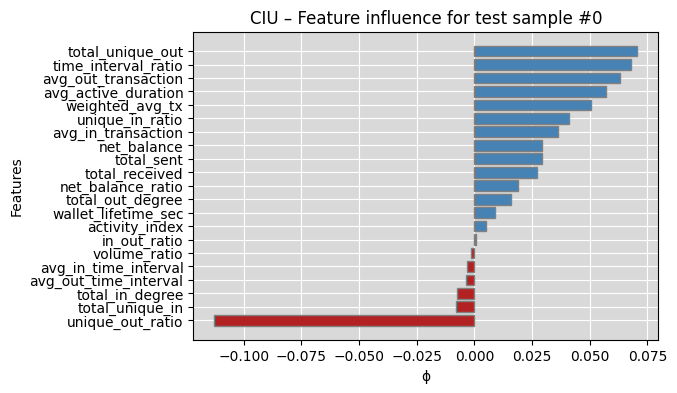

'\n### Optional: SHAP values\nUncomment the following cell if you prefer SHAP for global explanations (may be\nslow on large datasets):\n```python\nimport shap\n\n```\n'

In [11]:
# ----------------------------------------------------------------------
# CIU explainability block – run as needed
# ----------------------------------------------------------------------
from ciu import CIU

# Fit CIU on the original (non‑encoded) data – requires category mapping
category_mapping = {c: X[c].unique().tolist() for c in categorical_features}

ciu_explainer = CIU(
    predictor        = best_model.predict_proba,
    data             = X_train,  # range estimations
    input_names      = best_model.named_steps["preprocessor"].get_feature_names_out(),
    out_names        = le.classes_.tolist(),
    category_mapping = category_mapping,
    neutralCU        = 0.5,
    output_inds      = [0],  # index of positive class
)

# Pick an instance to explain
instance_idx = 0

sample_raw  = X_test.iloc[[instance_idx]]
ciu_result  = ciu_explainer.explain(sample_raw)

print("\n=== CIU – local explanation ===")
display(ciu_result.sort_values("Cinfl", ascending=False))

ciu_explainer.plot_influence(
    ciu_result,
    main=f"CIU – Feature influence for test sample #{instance_idx}",
)
plt.show()

# %% [markdown]
"""
### Optional: SHAP values
Uncomment the following cell if you prefer SHAP for global explanations (may be
slow on large datasets):
```python
import shap

```
"""


In [12]:
import shap

# # -------- Option A: generic Explainer on Pipeline.predict --------
# logger.info("Computing SHAP values (generic Explainer)…")
# explainer   = shap.Explainer(best_model.predict, X_train, feature_names=X.columns)
# shap_values = explainer(X_train)

# shap.plots.beeswarm(shap_values, max_display=20)  # global importance

# -------- Option B: TreeExplainer on RF + encoded data --------
logger.info("Computing SHAP values (TreeExplainer)…")
X_train_enc   = best_model.named_steps['preprocessor'].transform(X_train)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
explainer     = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values   = explainer.shap_values(X_train_enc)

/opt/anaconda3/envs/dexire-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-12 08:32:58,597 – INFO – Computing SHAP values (TreeExplainer)…


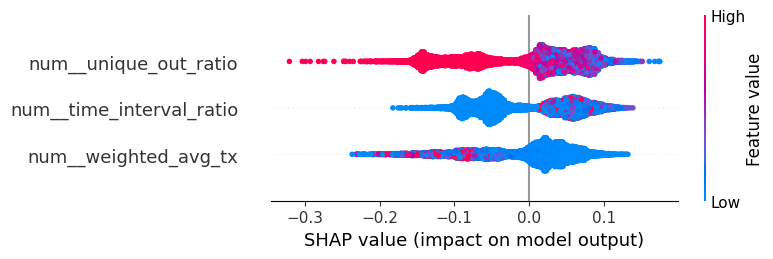

In [13]:
shap.summary_plot(shap_values[:, :, 0], 
                  features=X_train_enc, 
                  feature_names=feature_names,
                  max_display=3)


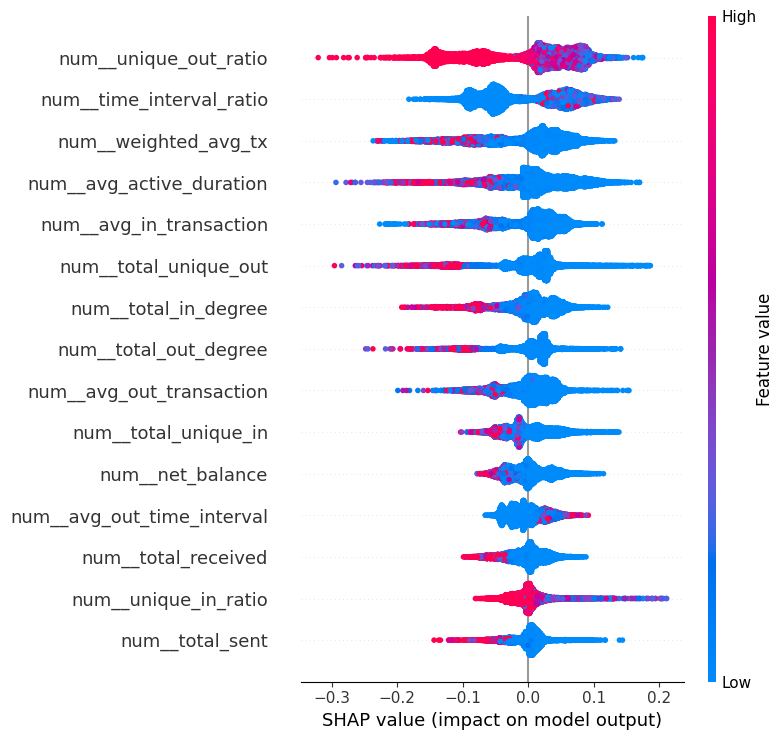

In [14]:
import matplotlib.pyplot as plt
import shap

# Imposti la dimensione della figura (opzionale, per controllare l’ingombro)
plt.figure(figsize=(12, 8))

# Generate summary plot without showing it immediately
shap.summary_plot(
    shap_values[:, :, 0],
    features=X_train_enc,
    feature_names=feature_names,
    max_display=15,
    show=False      # <-- qui disabiliti il display automatico
)

# Save as PNG at 300 dpi (or use SVG/PDF for vector format)
plt.savefig(
    'shap_summary.png',    # output filename
    dpi=300,               # resolution in dots per inch
    bbox_inches='tight'    # trim excess white margins
)